In [1]:
import random
import re
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyarrow
import seaborn as sns
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud

import infineac.constants as constants
import infineac.compare_results as compare_results
import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.process_text as process_text
import infineac.topic_extractor as topic_extractor
from infineac.pipeline import pipeline

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
KEYWORDS = ["russia", "ukraine"]
BASE_YEAR = 2013
random.seed(111)

c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load NLP model

In [2]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

2023-12-19 17:12:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-12-19 17:12:06 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-12-19 17:12:06 WARNING: GPU requested, but is not available!
2023-12-19 17:12:06 INFO: Using device: cpu
2023-12-19 17:12:06 INFO: Loading: tokenize
2023-12-19 17:12:06 INFO: Loading: lemma
2023-12-19 17:12:07 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [3]:
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 360433/360433 [40:57<00:00, 146.66it/s] 


Create a DataFrame with all companies and the corresponding year.

In [4]:
all_comp_df = pl.DataFrame(
    {
        "company_name": [event["company_name"] for event in events],
        "year": [event["date"].year for event in events if "date" in event.keys()],
    }
)
all_comp_df = all_comp_df.with_columns(year=pl.col("year").cast(pl.Int32))
all_comp_df = all_comp_df.filter(pl.col("year") >= BASE_YEAR)
all_comp_df = all_comp_df.unique()
helper.save_data(all_comp_df, "../output/cache/all_comp_df.lz4")

Check if all positions are valid.

In [5]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [6]:
events_filt_all = process_event.filter_events(
    events, year=BASE_YEAR, keywords=KEYWORDS, modifier_words=[]
)
events_filt = process_event.filter_events(events, year=BASE_YEAR, keywords=KEYWORDS)
helper.save_data(events_filt, "../output/cache/events_filt.lz4")
len(events_filt)

Filtering events


Events: 100%|██████████| 360433/360433 [02:48<00:00, 2141.36it/s]


Filtering events


Events: 100%|██████████| 360433/360433 [19:10<00:00, 313.31it/s] 


35146

List all **events**, that are filtered out due to modifier words preceding the keywords.

In [7]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=KEYWORDS, modifier_words=[], nlp_model=nlp_stanza)

32
Extracting passages from events


Events: 100%|██████████| 32/32 [00:02<00:00, 14.25it/s]


[[[[['Conversion increased 37% in Europe, and revenue increased 20% per transaction -- this is excluding Russia.']]],
  []],
 [[[['Next year the Genk facility will close at year-end, significantly contributing to an 18% reduction in our capacity in Europe excluding Russia and generating savings in 2015 and beyond.']]],
  []],
 [[[['Growth throughout the Central and Eastern Europe region was up 14.8%, with positive growth in all markets except Ukraine.']]],
  []],
 [[[['Revenue in Northern, Central and Eastern Europe grew by 4.5%, with positive trends in all countries except Russia and particularly high number in the UK and the Netherlands.']]],
  []],
 [[[['Looking at our European business, the top line is up 1% in local currency, and excluding Russia, retail growth was 2% with expansion in Switzerland, Germany and Spain, offset by market-related pressures in Italy and turnaround activity in South Africa.']]],
  []],
 [[[['Excluding Russia, where production was down 33%, Europe product

List some sentences, that are later filtered out due to modifier words preceding the keywords.

In [8]:
excluded_sentences_mod = process_event.excluded_sentences_by_mod_words(
    events_filt, keywords=KEYWORDS, nlp_model=nlp_stanza
)
excluded_sentences_mod_samples = random.sample(
    excluded_sentences_mod, min(25, len(excluded_sentences_mod))
)
with open("../output/samples/excluded_sentences_mod_samples.txt", "w") as f:
    for item in excluded_sentences_mod_samples:
        f.write("%s\n" % item.strip())
excluded_sentences_mod_samples

Documents: 100%|██████████| 469/469 [11:51<00:00,  1.52s/it]


['To have a bit more understanding about the work done on the financing side, please go to Page 17, where we show you the change of financing costs over periods, starting in the year 2014, where we have almost 4% cost of financing, including hedging costs but excluding Russia already.',
 'Excluding Russia and Ukraine, our pro forma adjusted diluted EPS of $1.46 grew by plus 16%.',
 '\r\n Global beverage can shipments, excluding Russia, increased 3.1% year-to-date and 5.7% in the third quarter.',
 'Excluding Russia, our retail comp was up 4.1%.',
 'We remain committed to our 2021-2023 CAGR target, excluding Russia and Ukraine of more than 5% growth in organic net revenues and more than 9% currency neutral growth in adjusted diluted earnings per share.',
 'Here, we have excluded Russia, just so you can get a sense for the development, excluding Russia, I will comment also later on what it would look like with Russia.',
 "If we move to the other European countries, they're up 6% when comp

## Exploration

In [4]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company_name = [event['company_name'] for event in events_filt]
company_ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in company_ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
year = [d.year for d in dates]
numeric_values = mdates.date2num(dates)

russia_or_ukr_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
ukraine_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('ukraine') for event in events_filt]
russia_or_ukraine_count = np.array(russia_count) + np.array(ukraine_count)
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [5]:
df_count_keywords = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company_name': company_name,
                   'ticker':company_ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'year': year,
                   'dates_num' : numeric_values,
                   'russia': russia_or_ukr_and_sanction,
                   'russia_count': russia_count,
                   'ukraine_count': ukraine_count,
                   'russia_or_ukraine_count': russia_or_ukraine_count,
                   'sanction_count': sanction_count,
                   'election': election})

Aggregate the data by **company** and **year**.

In [7]:
df_count_keywords_comp = pl.DataFrame(
    df_count_keywords[
        ["year", "company_name", "russia_count", "ukraine_count", "sanction_count"]
    ]
)
df_count_keywords_comp = df_count_keywords_comp.group_by("company_name", "year").agg(
    pl.col("russia_count", "ukraine_count", "sanction_count").sum()
)
df_count_keywords_comp = df_count_keywords_comp.with_columns(
    year=pl.col("year").cast(pl.Int32)
)
helper.save_data(df_count_keywords_comp, "../output/cache/df_count_keywords_comp.lz4")
df_count_keywords_comp

company_name,year,russia_count,ukraine_count,sanction_count
str,i32,i64,i64,i64
"""Societe BIC SA…",2013,3,2,0
"""SMA Solar Tech…",2013,1,0,0
"""Areva SA""",2013,1,0,0
"""TWDC Enterpris…",2013,12,0,0
"""Baxter Interna…",2013,7,0,0
"""Mistras Group …",2013,9,0,0
"""CEZ as""",2013,2,0,0
"""Beam Suntory I…",2013,22,0,0
"""Nexans SA""",2013,7,0,0


Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

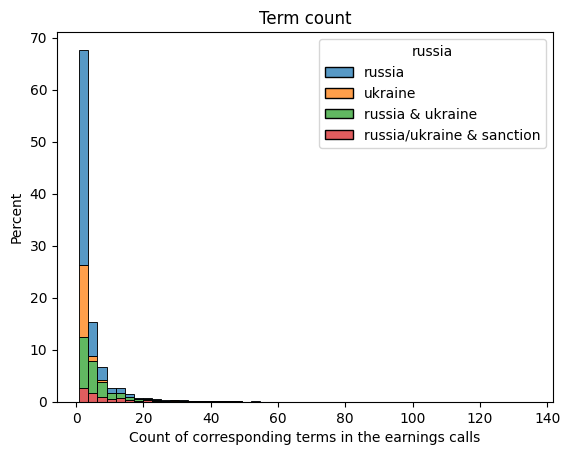

In [12]:
sns.histplot(
    df_count_keywords[
        (df_count_keywords["russia_count"] >= 1)
        | (df_count_keywords["ukraine_count"] >= 1)
    ],
    x="russia_or_ukraine_count",
    hue="russia",
    bins=50,
    stat="percent",
    common_norm=True,
    multiple="stack",
)
plt.xlabel("Count of corresponding terms in the earnings calls")
plt.ylabel("Percent")
plt.title("Term count")

plt.savefig("../output/figures/term_count.png", bbox_inches="tight")
plt.show()

Average mentions of "russia" per earnings call.

In [13]:
np.array(russia_count).mean()

3.1931087463722756

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [14]:
np.array([el for el in russia_count if el > 0]).mean()

3.773283572052989

Average mentions of "sanction" per earnings call.

In [15]:
np.array([el for el in sanction_count if el > 0]).mean()

2.348790322580645

Event distribution over time highlighting the different categories.

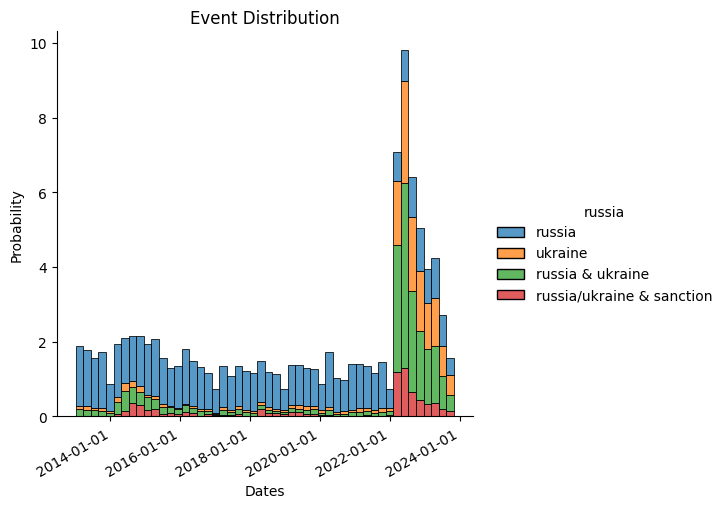

In [16]:
sns.displot(
    df_count_keywords,
    x="dates_num",
    hue="russia",
    bins=50,
    stat="percent",
    common_norm=True,
    multiple="stack",
)
plt.xlabel("Dates")
plt.ylabel("Probability")
plt.title("Event Distribution")

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(
    mdates.DateFormatter("%Y-%m-%d")
)  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.savefig("../output/figures/event_distribution.png", bbox_inches="tight")
plt.show()

Event proportion over time highlighting the different categories.

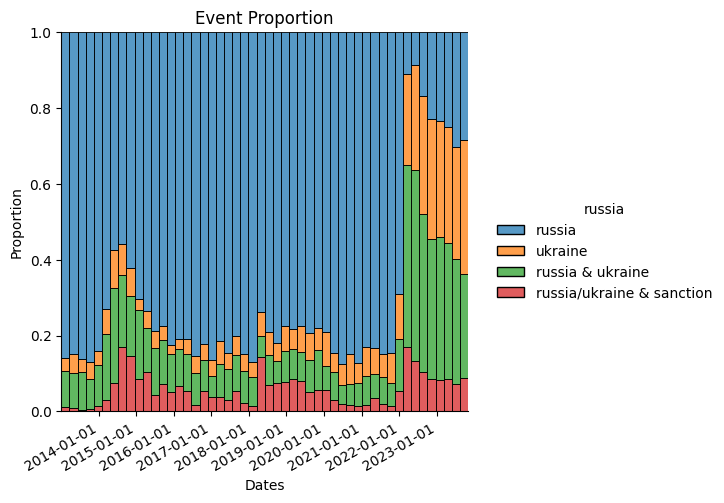

In [17]:
sns.displot(
    df_count_keywords,
    x="dates_num",
    hue="russia",
    bins=50,
    stat="proportion",
    common_norm=True,
    multiple="fill",
)
plt.xlabel("Dates")
plt.ylabel("Proportion")
plt.title("Event Proportion")

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(
    mdates.DateFormatter("%Y-%m-%d")
)  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.savefig("../output/figures/event_proportion.png", bbox_inches="tight")
plt.show()

## Preprocess and extract corpus

In [18]:
# events_filt = helper.load_data("..output/chache/events_filt.lz4")

By varying the window size and other parameters, we create different types of
corpora to obtain insights into the significance of these parameters. We will
compare the different results of the corpora to find the set of parameters,
which suits our purpose best.

The different corpora are:

1. Corpus with a window of [0,1] sentence and not joining adjacent sentences.
2. Corpus with a window of [0,1] sentence and joining adjacent sentences.
3. Corpus with a window of [0,3] sentences and joining adjacent sentences.
4. Corpus with a window of [0,5] sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [19]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_df.head()

Extracting passages from events


Events: 100%|██████████| 35146/35146 [1:14:30<00:00,  7.86it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 127202/127202 [31:09<00:00, 68.06it/s] 


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""Moving on to E…","""move emea emer…",4209565,2013,2013-01-29 16:00:00,"""Graco Inc"""
1,0,0,0,0,"""In internation…","""international …",4712249,2013,2013-08-06 15:00:00,"""Molson Coors B…"
2,0,0,0,0,"""Carling gained…","""carling gain m…",4712256,2013,2013-11-06 16:00:00,"""Molson Coors B…"
2,0,0,0,1,"""And we launche…","""launch brand""",4712256,2013,2013-11-06 16:00:00,"""Molson Coors B…"
3,0,0,0,0,"""In Russia, ong…","""ongoing distri…",4758643,2013,2013-02-05 14:30:00,"""Estee Lauder C…"


In [20]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_0_join_df)

Extracting passages from events


Events: 100%|██████████| 35146/35146 [48:43<00:00, 12.02it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 112282/112282 [27:18<00:00, 68.53it/s] 


112282

In [21]:
corpus_window_3_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,2],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_3_df)

Extracting passages from events


Events: 100%|██████████| 35146/35146 [48:25<00:00, 12.10it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 105803/105803 [32:24<00:00, 54.40it/s] 


105803

In [22]:
corpus_window_5_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,4],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_5_df)

Extracting passages from events


Events: 100%|██████████| 35146/35146 [47:35<00:00, 12.31it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 104118/104118 [33:33<00:00, 51.71it/s] 


104118

In [23]:
corpus_window_whole_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_whole_df)

Extracting passages from events


Events: 100%|██████████| 35146/35146 [47:51<00:00, 12.24it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 103987/103987 [39:32<00:00, 43.84it/s] 


103987

Save and load data

In [24]:
helper.save_data(corpus_window_0_df, "../output/cache/corpus_window_0_df_no_answer.lz4")
helper.save_data(corpus_window_0_join_df, "../output/cache/corpus_window_0_join_df_no_answer.lz4")
helper.save_data(corpus_window_3_df, "../output/cache/corpus_window_3_join_df_no_answer.lz4")
helper.save_data(corpus_window_5_df, "../output/cache/corpus_window_5_join_df_no_answer.lz4")
helper.save_data(corpus_window_whole_df, "../output/cache/corpus_window_whole_join_df_no_answer.lz4")

In [8]:
corpus_window_0_df = helper.load_data(
    "../output/cache/corpus_window_0_df_no_answer.lz4"
)
corpus_window_0_join_df = helper.load_data(
    "../output/cache/corpus_window_0_join_df_no_answer.lz4"
)
corpus_window_3_df = helper.load_data(
    "../output/cache/corpus_window_3_join_df_no_answer.lz4"
)
corpus_window_5_df = helper.load_data(
    "../output/cache/corpus_window_5_join_df_no_answer.lz4"
)
corpus_window_whole_df = helper.load_data(
    "../output/cache/corpus_window_whole_join_df_no_answer.lz4"
)
all_comp_df = helper.load_data("../output/cache/all_comp_df.lz4")
df_count_keywords_comp = helper.load_data("../output/cache/df_count_keywords_comp.lz4")

## Extract Strategies

Add different strategies to the corpus:

In [9]:
corpus_window_0_df = process_text.get_strategies(dataframe=corpus_window_0_df)
corpus_window_0_join_df = process_text.get_strategies(dataframe=corpus_window_0_join_df)
corpus_window_3_df = process_text.get_strategies(dataframe=corpus_window_3_df)
corpus_window_5_df = process_text.get_strategies(dataframe=corpus_window_5_df)
corpus_window_whole_df = process_text.get_strategies(dataframe=corpus_window_whole_df)

Strategies:   0%|          | 0/3 [00:00<?, ?it/s]

Strategies: 100%|██████████| 3/3 [00:34<00:00, 11.35s/it]


Extract sample sentences for each strategy and save them.

In [10]:
strategy_samples = process_text.sample_strategies(corpus_window_0_df, 25)
with open("../output/samples/strategy_samples.txt", "w") as f:
    for item in strategy_samples:
        f.write("%s\n" % item)

Count exit strategies for different corpora

In [11]:
print("Count of exit strategies in smallest corpus:", sum(corpus_window_0_df['exit_strategy']))
print("Count of exit strategies in biggest corpus:", sum(corpus_window_whole_df['exit_strategy']))

Count of exit strategies in smallest corpus: 3452
Count of exit strategies in biggest corpus: 4471


## Analyse the corpora

### Smallest corpus: [0,1] window and no join

In [12]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.max(np.array(lengths))

1634

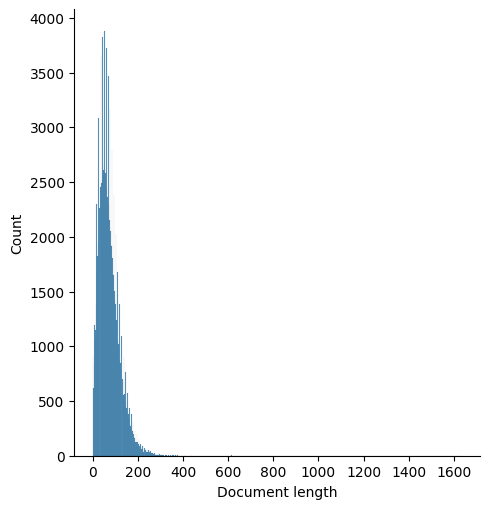

In [13]:
sns.displot(np.array(lengths))
plt.xlabel('Document length')
plt.savefig('../output/figures/document_length_sc.png', bbox_inches='tight')
plt.show()

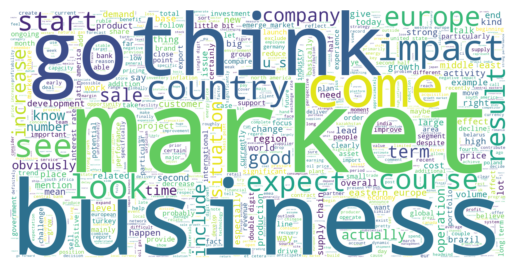

In [14]:
wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
wc.generate_from_text(" ".join(corpus_window_0_df['processed_text'].to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('../output/figures/wordcloud_sc.png', dpi=300, bbox_inches='tight')
plt.show()

### Biggest corpus: whole window and join adjacent sentences

In [15]:
lengths = [len(doc) for doc in corpus_window_whole_df['processed_text'].to_list()]
np.max(np.array(lengths))

6339

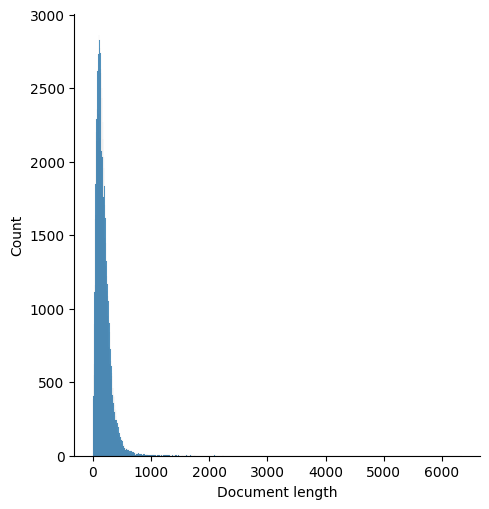

In [16]:
sns.displot(np.array(lengths))
plt.xlabel("Document length")
plt.savefig("../output/figures/document_length_whole.png", bbox_inches="tight")
plt.show()

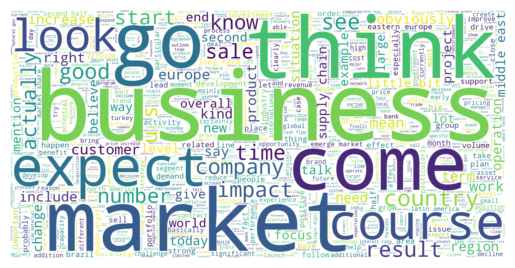

In [17]:
wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
wc.generate_from_text(" ".join(corpus_window_whole_df['processed_text'].to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('../output/figures/wordcloud_whole.png', dpi=300, bbox_inches='tight')
plt.show()

## Extract topics

In [18]:
# main_representation = KeyBERTInspired()
inspired_model = KeyBERTInspired()

# sentence model
sentence_model_light = SentenceTransformer("all-MiniLM-L6-v2")

# mmr model
mmr_model = MaximalMarginalRelevance(diversity=0.4)

# chain models
chain_model_1 = [inspired_model, mmr_model]

# Add all models together to be run in a single `fit`
representation_model = {
   "Main": inspired_model,
   "Chain: Inspired - MMR":  chain_model_1,
}

### 1 - Only target sentence
* Sentence window: 0
* No join

In [19]:
results_df_0, results_comp_0, categories_0, categories_count_0 = pipeline(preload_corpus=corpus_window_0_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 3875/3875 [07:59<00:00,  8.08it/s]
2023-12-19 17:27:31,207 - BERTopic - Transformed documents to Embeddings
2023-12-19 17:29:17,458 - BERTopic - Reduced dimensionality
2023-12-19 20:22:07,210 - BERTopic - Clustered reduced embeddings


In [20]:
categories_count_0

category,Count
str,i64
"""macro demand""",11557
"""finance""",10149
"""indirect geogr…",9623
"""commodity""",8935
"""misc""",6074
"""macro inflatio…",3266
"""supply chain""",2859
"""exchage rate""",2803
"""human ressourc…",1856


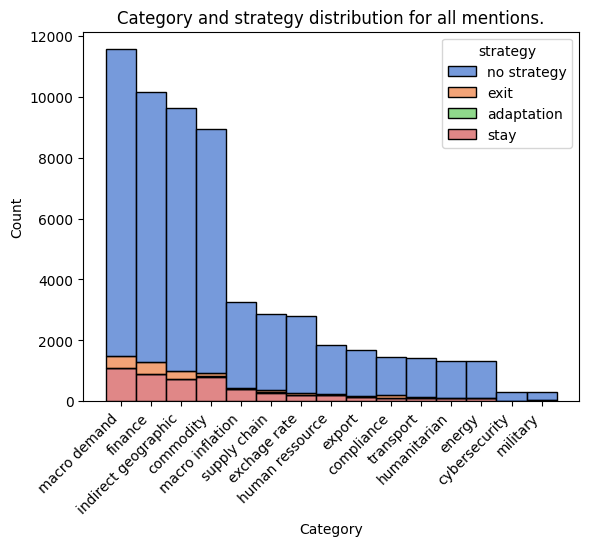

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",59065,1706,84,5635,51640
"""macro demand""",11557,397,12,1080,10068
"""finance""",10149,401,17,881,8850
"""indirect geogr…",9623,245,13,731,8634
"""commodity""",8935,123,10,809,7993
"""misc""",6074,120,9,408,5537
"""macro inflatio…",3266,33,2,393,2838
"""empty""",3224,63,1,124,3036
"""supply chain""",2859,85,5,285,2484


In [21]:
count_categories, plt = topic_extractor.plot_category_distribution(results_df_0)
plt.savefig('../output/figures/category_distribution_all_0.png', bbox_inches='tight')
plt.show()
count_categories

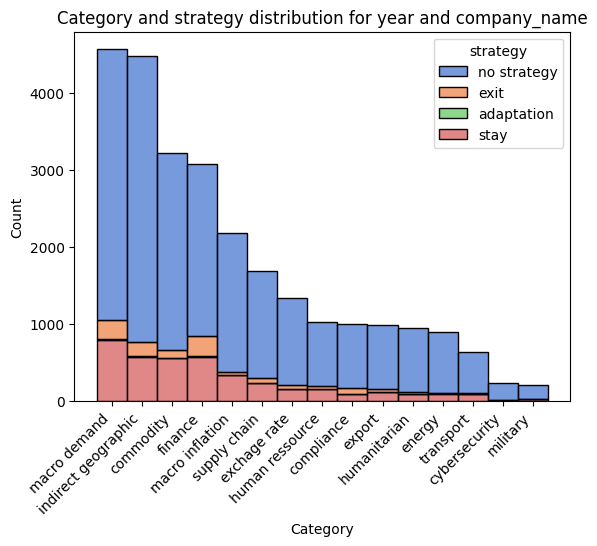

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",11940,916,77,3139,7808
"""macro demand""",4565,247,12,792,3514
"""indirect geogr…",4472,183,11,571,3707
"""commodity""",3224,95,8,557,2564
"""finance""",3078,268,14,569,2227
"""misc""",3049,103,8,315,2623
"""macro inflatio…",2177,31,2,342,1802
"""empty""",1993,58,1,111,1823
"""supply chain""",1690,70,5,232,1383


In [22]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_0, aggregate=["year", "company_name"]
)
plt.savefig("../output/figures/category_distribution_comp_0.png", bbox_inches="tight")
plt.show()
count_categories

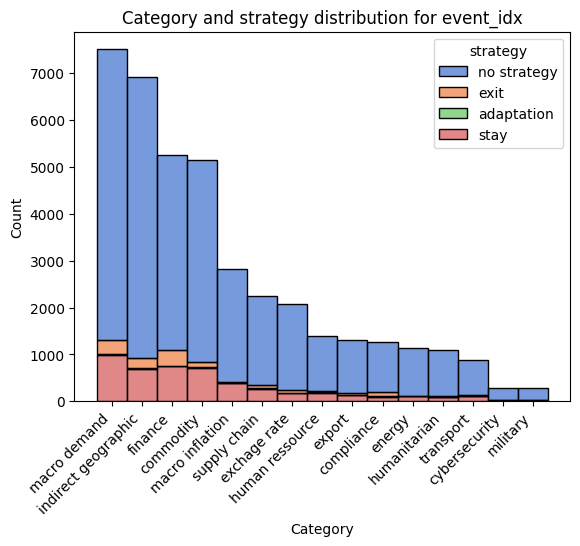

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",24354,1274,81,4550,18449
"""macro demand""",7511,314,12,992,6193
"""indirect geogr…",6925,217,12,689,6007
"""finance""",5253,332,17,743,4161
"""commodity""",5147,111,10,716,4310
"""misc""",4428,115,9,378,3926
"""macro inflatio…",2812,32,2,382,2396
"""empty""",2587,60,1,119,2407
"""supply chain""",2253,80,5,272,1896


In [23]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_0, aggregate=["event_idx"]
)
plt.savefig("../output/figures/category_distribution_event_0.png", bbox_inches="tight")
plt.show()
count_categories

In [24]:
results_comp_0 = results_comp_0.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_0 = all_comp_df.join(
    results_comp_0, on=["company_name", "year"], how="left"
)

In [25]:
helper.save_data(results_df_0, "../output/results/corpus_window_0_df_topic.lz4")
all_comp_results_0.write_excel("../output/results/topics_comp_0.xlsx")

In [26]:
for category in list(constants.CATEGORIES_TOPICS.keys()):
    list_categories = list(results_df_0.filter(pl.col("category") == category)["text"])
    sample_lst = random.sample(list_categories, min(25, len(list_categories)))
    with open("../output/samples/category_samples.txt", "a") as f:
        f.write("%s\n" % category)
        for item in sample_lst:
            f.write("%s\n" % item)
        f.write("\n\n")

### 2 - Only target sentence - join
* Sentence window: 0
* Join sentences

In [27]:
results_df_0_join, results_comp_0_join, categories_0_join, categories_count_0_join = pipeline(preload_corpus=corpus_window_0_join_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 3440/3440 [04:01<00:00, 14.27it/s]
2023-12-19 20:27:45,717 - BERTopic - Transformed documents to Embeddings
2023-12-19 20:28:44,163 - BERTopic - Reduced dimensionality
2023-12-19 21:41:48,449 - BERTopic - Clustered reduced embeddings


In [28]:
categories_count_0_join

category,Count
str,i64
"""macro demand""",9488
"""indirect geogr…",9174
"""commodity""",8184
"""finance""",8158
"""misc""",3691
"""supply chain""",3235
"""macro inflatio…",2643
"""exchage rate""",2313
"""export""",1505


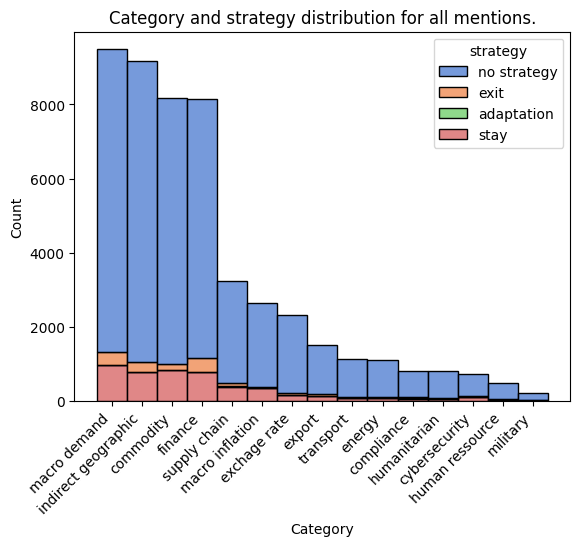

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",56307,1776,91,5892,48548
"""macro demand""",9488,354,8,976,8150
"""indirect geogr…",9174,257,13,781,8123
"""commodity""",8184,151,10,843,7180
"""finance""",8158,373,15,776,6994
"""misc""",3691,69,4,234,3384
"""supply chain""",3235,92,8,392,2743
"""macro inflatio…",2643,41,2,354,2246
"""exchage rate""",2313,50,1,174,2088


In [29]:
count_categories, plt = topic_extractor.plot_category_distribution(results_df_0_join)
plt.savefig('../output/figures/category_distribution_all_0_join.png', bbox_inches='tight')
plt.show()
count_categories

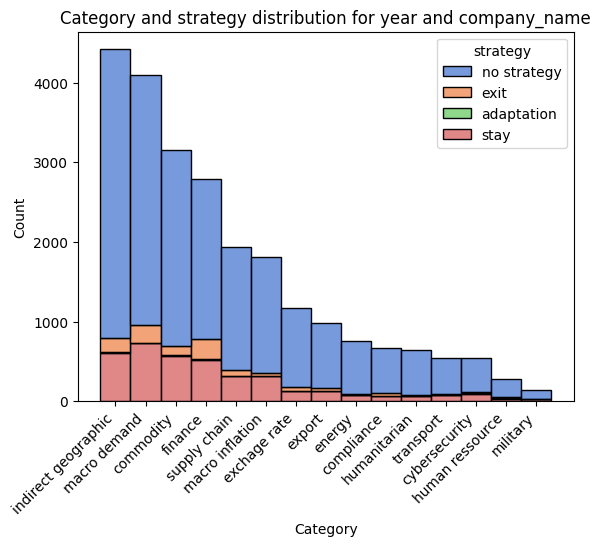

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",11965,938,83,3218,7726
"""indirect geogr…",4419,177,11,611,3620
"""macro demand""",4092,225,8,728,3131
"""commodity""",3150,120,10,567,2453
"""finance""",2796,259,11,514,2012
"""misc""",2245,60,4,207,1974
"""supply chain""",1942,74,8,314,1546
"""macro inflatio…",1806,37,2,318,1449
"""empty""",1529,35,0,79,1415


In [30]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_0_join, aggregate=["year", "company_name"]
)
plt.savefig("../output/figures/category_distribution_comp_0_join.png", bbox_inches="tight")
plt.show()
count_categories

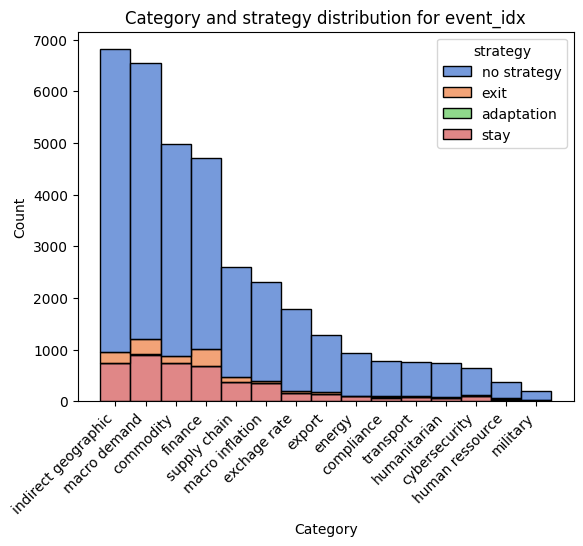

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",24476,1304,89,4725,18358
"""indirect geogr…",6812,218,12,732,5850
"""macro demand""",6539,291,8,901,5339
"""commodity""",4972,136,10,736,4090
"""finance""",4717,326,15,674,3702
"""misc""",3045,66,4,227,2748
"""supply chain""",2589,86,8,369,2126
"""macro inflatio…",2299,41,2,345,1911
"""empty""",1870,37,0,83,1750


In [31]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_0_join, aggregate=["event_idx"]
)
plt.savefig("../output/figures/category_distribution_event_0_join.png", bbox_inches="tight")
plt.show()
count_categories

In [32]:
results_comp_0_join = results_comp_0_join.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_0 = all_comp_df.join(
    results_comp_0_join, on=["company_name", "year"], how="left"
)

In [33]:
helper.save_data(results_df_0_join, "../output/results/corpus_window_0_join_df_topic.lz4")
all_comp_results_0.write_excel("../output/results/topics_comp_0_join.xlsx")

### 3 - 3 sentences - join
* Sentence window: 3
* Join sentences  

In [34]:
results_df_3, results_comp_3, categories_3, categories_count_3 = pipeline(preload_corpus=corpus_window_3_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 3278/3278 [05:21<00:00, 10.21it/s]
2023-12-19 21:48:43,645 - BERTopic - Transformed documents to Embeddings
2023-12-19 21:49:39,182 - BERTopic - Reduced dimensionality
2023-12-19 22:35:47,770 - BERTopic - Clustered reduced embeddings


In [35]:
categories_count_3

category,Count
str,i64
"""indirect geogr…",9242
"""commodity""",8379
"""finance""",7751
"""macro demand""",6350
"""supply chain""",2693
"""humanitarian""",2671
"""misc""",2352
"""macro inflatio…",1552
"""exchage rate""",1552


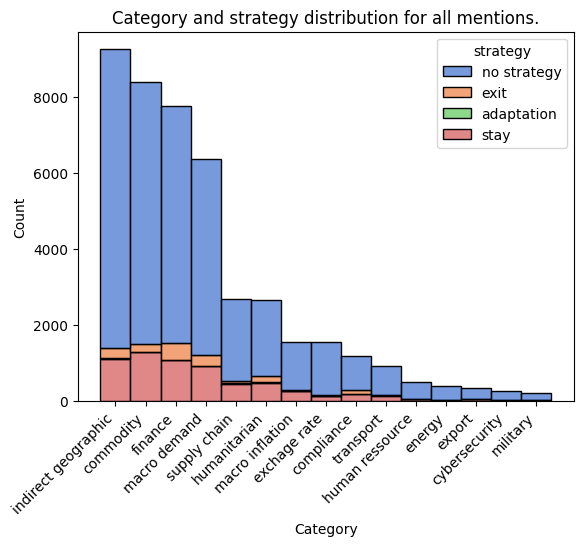

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",58483,2159,166,8715,47443
"""indirect geogr…",9242,265,18,1109,7850
"""commodity""",8379,202,13,1281,6883
"""finance""",7751,437,15,1076,6223
"""macro demand""",6350,276,14,916,5144
"""supply chain""",2693,59,7,464,2163
"""humanitarian""",2671,157,22,484,2008
"""misc""",2352,60,3,214,2075
"""macro inflatio…",1552,29,6,270,1247


In [36]:
count_categories, plt = topic_extractor.plot_category_distribution(results_df_3)
plt.savefig('../output/figures/category_distribution_all_3.png', bbox_inches='tight')
plt.show()
count_categories

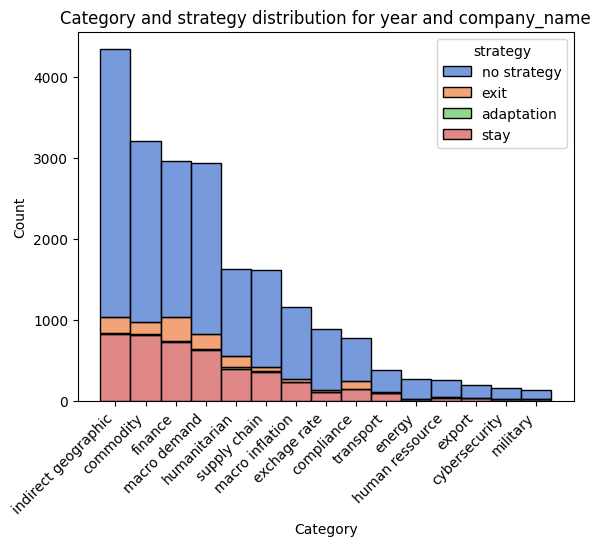

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",12405,1157,144,4304,6800
"""indirect geogr…",4341,189,17,830,3305
"""commodity""",3209,145,13,814,2237
"""finance""",2963,297,12,728,1926
"""macro demand""",2934,177,14,635,2108
"""humanitarian""",1630,139,20,397,1074
"""supply chain""",1618,52,7,366,1193
"""misc""",1505,50,3,179,1273
"""macro inflatio…",1167,28,5,237,897


In [37]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_3, aggregate=["year", "company_name"]
)
plt.savefig("../output/figures/category_distribution_comp_3.png", bbox_inches="tight")
plt.show()
count_categories

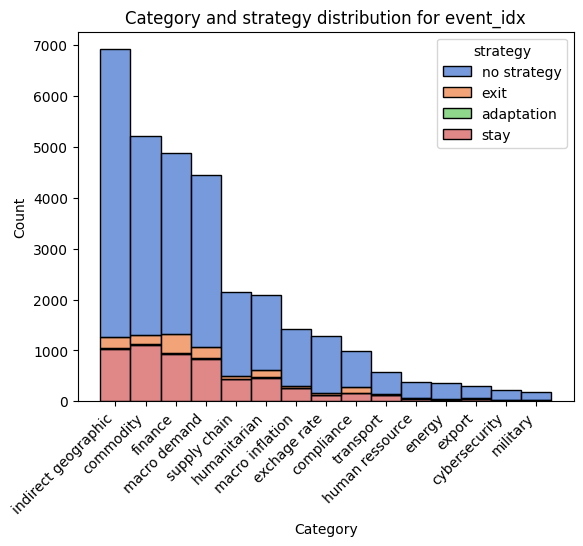

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",25453,1609,157,6629,17058
"""indirect geogr…",6919,227,17,1023,5652
"""commodity""",5223,180,13,1109,3921
"""finance""",4873,367,15,935,3556
"""macro demand""",4452,218,14,829,3391
"""supply chain""",2155,56,7,434,1658
"""humanitarian""",2090,149,21,450,1470
"""misc""",1981,56,3,207,1715
"""macro inflatio…",1413,29,6,262,1116


In [38]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_3, aggregate=["event_idx"]
)
plt.savefig("../output/figures/category_distribution_event_3.png", bbox_inches="tight")
plt.show()
count_categories

In [39]:
results_comp_3 = results_comp_3.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_3 = all_comp_df.join(
    results_comp_3, on=["company_name", "year"], how="left"
)

In [40]:
helper.save_data(results_df_3, "../output/results/corpus_window_3_df_topic.lz4")
all_comp_results_3.write_excel("../output/results/topics_comp_3.xlsx")

### 4. 5 sentences - join
* Sentence window: 5
* Join sentences

In [41]:
results_df_5, results_comp_5, categories_5, categories_count_5 = pipeline(preload_corpus=corpus_window_3_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 3278/3278 [05:22<00:00, 10.16it/s]
2023-12-19 22:42:43,447 - BERTopic - Transformed documents to Embeddings
2023-12-19 22:43:39,896 - BERTopic - Reduced dimensionality
2023-12-20 00:48:59,022 - BERTopic - Clustered reduced embeddings


In [42]:
categories_count_5

category,Count
str,i64
"""indirect geogr…",9242
"""commodity""",8379
"""finance""",7751
"""macro demand""",6350
"""supply chain""",2693
"""humanitarian""",2671
"""misc""",2352
"""exchage rate""",1552
"""macro inflatio…",1552


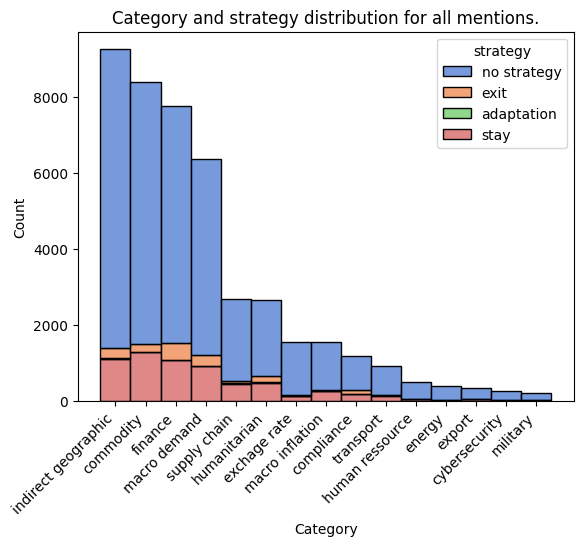

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",58483,2159,166,8715,47443
"""indirect geogr…",9242,265,18,1109,7850
"""commodity""",8379,202,13,1281,6883
"""finance""",7751,437,15,1076,6223
"""macro demand""",6350,276,14,916,5144
"""supply chain""",2693,59,7,464,2163
"""humanitarian""",2671,157,22,484,2008
"""misc""",2352,60,3,214,2075
"""exchage rate""",1552,29,0,134,1389


In [43]:
count_categories, plt = topic_extractor.plot_category_distribution(results_df_5)
plt.savefig('../output/figures/category_distribution_all_5.png', bbox_inches='tight')
plt.show()
count_categories

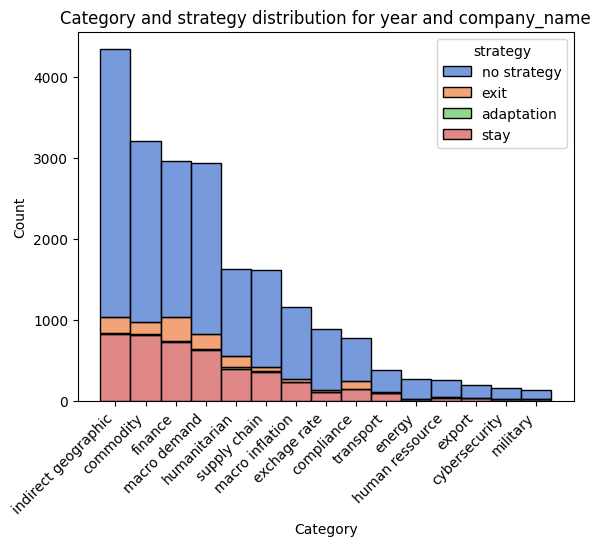

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",12405,1157,144,4304,6800
"""indirect geogr…",4341,189,17,830,3305
"""commodity""",3209,145,13,814,2237
"""finance""",2963,297,12,728,1926
"""macro demand""",2934,177,14,635,2108
"""humanitarian""",1630,139,20,397,1074
"""supply chain""",1618,52,7,366,1193
"""misc""",1505,50,3,179,1273
"""macro inflatio…",1167,28,5,237,897


In [44]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_5, aggregate=["year", "company_name"]
)
plt.savefig("../output/figures/category_distribution_comp_5.png", bbox_inches="tight")
plt.show()
count_categories

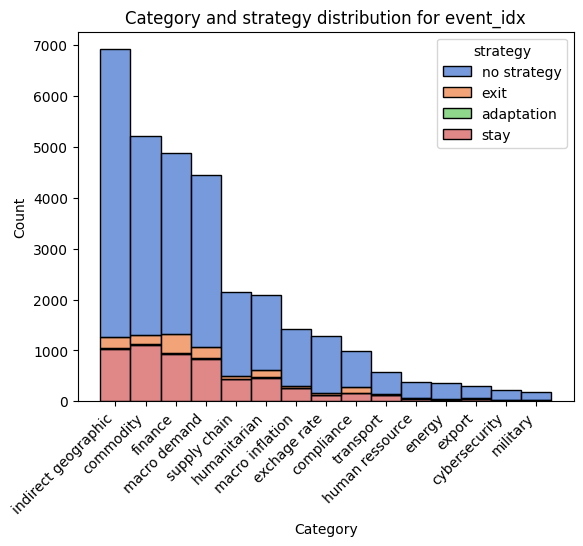

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",25453,1609,157,6629,17058
"""indirect geogr…",6919,227,17,1023,5652
"""commodity""",5223,180,13,1109,3921
"""finance""",4873,367,15,935,3556
"""macro demand""",4452,218,14,829,3391
"""supply chain""",2155,56,7,434,1658
"""humanitarian""",2090,149,21,450,1470
"""misc""",1981,56,3,207,1715
"""macro inflatio…",1413,29,6,262,1116


In [45]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_5, aggregate=["event_idx"]
)
plt.savefig("../output/figures/category_distribution_event_5.png", bbox_inches="tight")
plt.show()
count_categories

In [46]:
results_comp_5 = results_comp_5.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_5 = all_comp_df.join(
    results_comp_5, on=["company_name", "year"], how="left"
)

In [47]:
helper.save_data(results_df_5, "../output/results/corpus_window_5_df_topic.lz4")
all_comp_results_5.write_excel("../output/results/topics_comp_5.xlsx")

### 5. Whole paragraph - join
* Sentence window: whole paragraph
* Join sentences

In [48]:
results_df_whole, results_comp_whole, categories_whole, categories_count_whole = pipeline(preload_corpus=corpus_window_whole_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 3232/3232 [07:24<00:00,  7.27it/s]
2023-12-20 00:58:01,606 - BERTopic - Transformed documents to Embeddings
2023-12-20 00:58:56,747 - BERTopic - Reduced dimensionality
2023-12-20 01:35:27,389 - BERTopic - Clustered reduced embeddings


In [49]:
categories_count_whole

category,Count
str,i64
"""commodity""",6979
"""finance""",6172
"""indirect geogr…",6042
"""macro demand""",5803
"""macro inflatio…",3013
"""supply chain""",2104
"""misc""",1806
"""transport""",1402
"""exchage rate""",1358


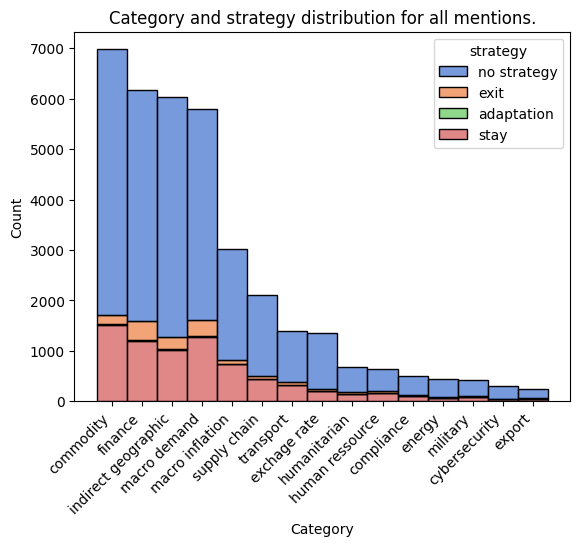

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",65515,2979,278,13804,48454
"""commodity""",6979,181,19,1520,5259
"""finance""",6172,370,24,1199,4579
"""indirect geogr…",6042,246,19,1008,4769
"""macro demand""",5803,316,18,1273,4196
"""macro inflatio…",3013,63,16,730,2204
"""supply chain""",2104,55,4,436,1609
"""misc""",1806,44,3,276,1483
"""transport""",1402,48,12,319,1023


In [50]:
count_categories, plt = topic_extractor.plot_category_distribution(results_df_whole)
plt.savefig('../output/figures/category_distribution_all_whole.png', bbox_inches='tight')
plt.show()
count_categories

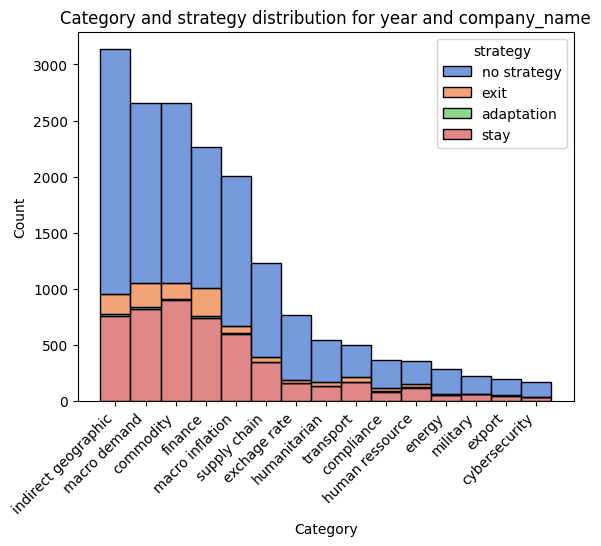

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",13072,1579,238,5952,5303
"""indirect geogr…",3135,179,18,760,2178
"""macro demand""",2659,214,18,825,1602
"""commodity""",2653,138,17,898,1600
"""finance""",2261,249,21,738,1253
"""macro inflatio…",2007,57,16,595,1339
"""supply chain""",1229,45,4,347,833
"""misc""",1163,38,3,216,906
"""exchage rate""",767,24,0,165,578


In [51]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_whole, aggregate=["year", "company_name"]
)
plt.savefig("../output/figures/category_distribution_comp_whole.png", bbox_inches="tight")
plt.show()
count_categories

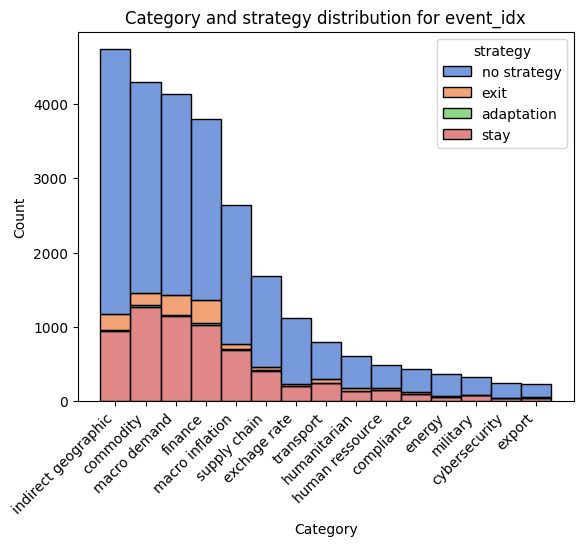

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",27457,2195,265,9738,15259
"""indirect geogr…",4732,216,19,942,3555
"""commodity""",4293,167,19,1274,2833
"""macro demand""",4132,268,18,1140,2706
"""finance""",3793,317,24,1024,2428
"""macro inflatio…",2637,61,16,690,1870
"""supply chain""",1684,50,4,411,1219
"""misc""",1527,42,3,262,1220
"""exchage rate""",1126,33,0,201,892


In [52]:
count_categories, plt = topic_extractor.plot_category_distribution(
    results_df_whole, aggregate=["event_idx"]
)
plt.savefig("../output/figures/category_distribution_event_whole.png", bbox_inches="tight")
plt.show()
count_categories

In [53]:
results_comp_whole = results_comp_whole.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_whole = all_comp_df.join(
    results_comp_whole, on=["company_name", "year"], how="left"
)

In [54]:
helper.save_data(results_df_whole, "../output/results/corpus_window_whole_df_topic.lz4")
all_comp_results_whole.write_excel("../output/results/topics_comp_whole.xlsx")

## Join results

In [55]:
# results_df_0 = helper.load_data("../output/results/corpus_window_0_df_topic.lz4")
# results_df_0_join = helper.load_data("../output/results/corpus_window_0_join_df_topic.lz4")
# results_df_3 = helper.load_data("../output/results/corpus_window_3_df_topic.lz4")
# results_df_5 = helper.load_data("../output/results/corpus_window_5_df_topic.lz4")
# results_df_whole = helper.load_data("../output/results/corpus_window_whole_df_topic.lz4")

In [56]:
results_comp_compare = compare_results.create_compare_df(
    [
        results_comp_0,
        results_comp_0_join,
        results_comp_3,
        results_comp_5,
        results_comp_whole,
    ],
    ["_0", "_0_join", "_3", "_5", "_whole"],
)
results_comp_compare = compare_results.calculate_similarity(results_comp_compare)

In [57]:
results_comp_compare.select(
    pl.mean("jaccard_topic_pairwise"),
    pl.mean("jaccard_category_pairwise"),
    pl.mean("jaccard_topic_combined"),
    pl.mean("jaccard_category_combined"),
)

jaccard_topic_pairwise,jaccard_category_pairwise,jaccard_topic_combined,jaccard_category_combined
f64,f64,f64,f64
0.091299,0.620155,0.002789,0.345914


In [58]:
helper.save_data(results_comp_compare, "../output/results/results_comp_compare.lz4")
results_comp_compare.write_excel("../output/results/results_comp_compare.xlsx")

In [77]:
results_comp_compare_all = all_comp_df.join(
    results_comp_compare, on=["company_name", "year"], how="left"
)
results_comp_compare_all = results_comp_compare_all.with_columns(
    pl.col(
        [
            "russia_count",
            "ukraine_count",
            "sanction_count",
            "exit_strategy",
            "stay_strategy",
            "adaptation_strategy",
        ]
    ).fill_null(0),
    pl.col(
        [
            "topic_0",
            "topic_0_join",
            "topic_3",
            "topic_5",
            "topic_whole",
            "topic_intersection",
            "topic_union",
            "category_0",
            "category_0_join",
            "category_3",
            "category_5",
            "category_whole",
            "category_intersection",
            "category_union",
        ]
    ).fill_null([]),
)
results_comp_compare_all.write_excel("../output/results/results_comp_compare_all.xlsx")

In [59]:
count_categories = compare_results.aggregate_results(results_comp_compare)
count_categories.to_pandas()

,category,strategy,intersection,union
0,commodity,exit,257,709
1,commodity,stay,862,2241
2,commodity,adaptation,29,78
3,commodity,no strategy,706,2403
4,compliance,exit,48,532
5,compliance,stay,63,1074
6,compliance,adaptation,4,56
7,compliance,no strategy,23,580
8,cybersecurity,exit,10,227
9,cybersecurity,stay,32,436


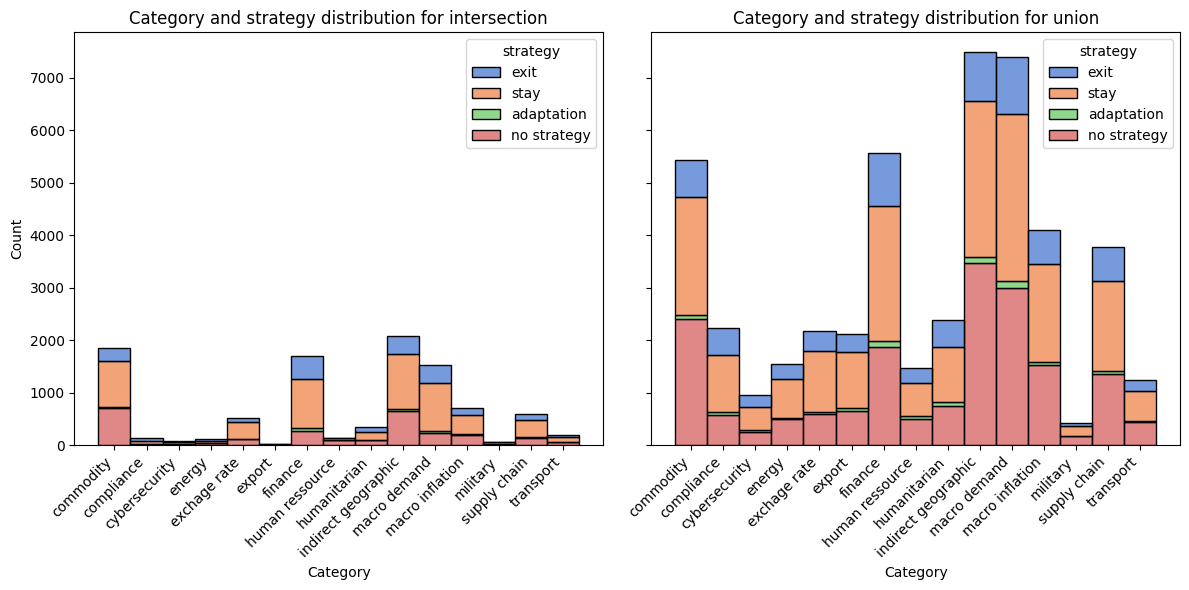

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the first figure
sns.histplot(
    count_categories.to_pandas(),
    x="category",
    hue="strategy",
    weights="intersection",
    common_norm=True,
    multiple="stack",
    palette="muted",
    ax=ax1,
)
ax1.set_xlabel("Category")
ax1.set_ylabel("Count")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment="right")
ax1.set_title("Category and strategy distribution for intersection")

# Plot the second figure
sns.histplot(
    count_categories.to_pandas(),
    x="category",
    hue="strategy",
    weights="union",
    common_norm=True,
    multiple="stack",
    palette="muted",
    ax=ax2,
)
ax2.set_xlabel("Category")
ax2.set_ylabel("Count")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment="right")
ax2.set_title("Category and strategy distribution for union")

fig.savefig(
    "../output/figures/category_strategy_distribution_intersection_union.png",
    bbox_inches="tight",
)

plt.tight_layout()
plt.show()